# Monte Carlo Model of $A_n$ + $B_m$ Polycondensation

## Introduction

This is a simple implementation of a Monte Carlo algorithm to compute the evolution of the chain-length distribution in a classical $A_n$ + $B_m$ polycondensation reaction. The solution is obtained as a function of the conversion of endgroups of type $A$, which is assumed to be the limiting species, rather than as a function of time.

Typically, stochastic simulations of chemical reactions are performed using [Gillespie's algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm). However, since this case involves only one reaction and we are not focused on the temporal evolution, a simpler approach is sufficient. In simple terms, the algorithm proceeds as follows:

1. Build an array of molecules and populate it with the initial number of $A_n$ and $B_m$ molecules.
1. Randomly select a molecule with an endgroup of type $A$.
1. Randomly select a different molecule with an endgroup of type $B$. By ensuring that two distinct molecules are chosen, cyclization is excluded.
1. Create a new product molecule by joining/condensing the two selected molecules.
1. Update the array by removing the reacted molecules and adding the newly formed molecule.
1. Count the remaining functional groups to calculate the degree of conversion for the ensemble.
1. If the conversion is below the target value, repeat from step 2. Otherwise, stop.


## Numerical Solution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

### State Matrix

The foundation of the algorithm is a _state_ matrix, where each row is an _internal property_ to be tracked and each column is a _molecule_. Visually, it looks like so:  

|              | 1 | 2 | ... | `number_molecules_start` |
|--------------|---|---|-----|--------------------------|
| `idx_active` |   |   |     |                          |
| `idx_nA`     |   |   |     |                          |
| `idx_nB`     |   |   |     |                          |
| `idx_egA`    |   |   |     |                          |
| `idx_egB`    |   |   |     |                          |

To improve code readability, we define _named_ variables that point to the corresponding row index in the state matrix. 

In [2]:
idx_active = 0  # active (not consumed) molecule
idx_nA = 1      # number of embeded An molecules
idx_nB = 2      # number of embeded Bm molecules
idx_egA = 3     # number of endgroups of type A
idx_egB = 4     # number of endgroups of type B
num_idx = 5     # total number of properties/rows

### State Functions

Having set the layout of the state array, we can now define functions that operate on the state matrix to extract quantitative information about the ensemble, such as the number of molecules, the conversion of endgroups, etc. 

In [3]:
# Some of these functions are written in a generic way, so that they can
# accept a state matrix (2D) or a vector of state matrices (3D).

@njit(fastmath=True)
def get_number_molecules(state: np.ndarray):
    "Return number of molecules."
    return np.sum(state[..., idx_active, :], axis=-1)

@njit(fastmath=True) 
def get_conversion_A(state: np.ndarray, fA: int):
    "Return conversion of `A` groups."
    NA0 = fA*np.sum(state[..., idx_nA, :], axis=-1)
    NA = np.sum(state[..., idx_egA, :], axis=-1)
    return 1.0 - NA / NA0

@njit(fastmath=True)
def cumsum_norm(a: np.ndarray) -> np.ndarray:
    "Return normalized cumulative sum of array elements."
    result = np.cumsum(a).astype(np.float64)
    result /= max(1.0, result[-1])
    return result

def get_moment(state: np.ndarray, k: int):
    "Return k-th _positive_ moment."
    return np.sum((state[..., idx_nA, :] + state[..., idx_nB, :])**k, axis=-1)

def get_chain_lengths(state: np.ndarray):
    "Return array of chain lengths."
    return state[..., idx_nA, :] + state[..., idx_nB, :]

### Stochastic Algorithm

Now, we are ready to implement the actual Monte Carlo algorithm.

In [4]:
@njit(fastmath=False, parallel=True)
def simulate_polycondensation(number_molecules_start: int,
                              ratio_endgroups_A_B: float,
                              conversion_A_stop: float,
                              fA: int,
                              fB: int,
                              ) -> list[np.ndarray]:
    """Simulate polycondensation by Monte Carlo.

    Parameters
    ----------
    number_molecules_start : int
        Initial number of molecules.
    ratio_endgroups_A_B : float
        Initial molar ratios of endgroups A and B.
    conversion_A_stop : float
        Stop condition for conversion of A groups.
    fA : int
        Functionality of monomer A.
    fB : int
        Functionality of monomer B.

    Returns
    -------
    list[np.ndarray]
        State snapshots.
    """

    # Initial stoichiometry
    ratio_endgroups_A_B = min(1.0, ratio_endgroups_A_B)
    molefrac_A = ratio_endgroups_A_B/(fA/fB + ratio_endgroups_A_B)
    number_molecules_start_A = round(number_molecules_start*molefrac_A)

    # Gel condition according to Stockmayer
    x_gel = 1/np.sqrt(ratio_endgroups_A_B*(fA - 1)*(fB - 1))
    if x_gel < 1.0:
        print("Warning: gelation at x_gel=", x_gel)  # no f-strings in numba

    # Initialize state matrix to store current state of all molecules
    state = np.zeros((num_idx, number_molecules_start), dtype=np.int32)

    # Populate state array with monomer molecules
    state[idx_active, :] = 1
    # Add molecules A(fA)
    state[idx_nA, :number_molecules_start_A] = 1
    state[idx_egA, :number_molecules_start_A] = fA
    # Add molecules B(fB)
    state[idx_nB, number_molecules_start_A:] = 1
    state[idx_egB, number_molecules_start_A:] = fB

    # Schuffle molecules
    np.random.shuffle(state.T)

    # MC algorithm
    stored_states = []
    number_stored_states = 200
    conversion_A_last = 0.0
    while True:

        # Randomly select a molecule with endgroup A
        cumsum_fA = cumsum_norm(state[idx_egA, :])
        index_molecule1 = np.searchsorted(cumsum_fA, np.random.rand())
        molecule1 = state[:, index_molecule1]

        # Randomly select a _distinct_ molecule with endgroup B
        while True:
            cumsum_fB = cumsum_norm(state[idx_egB, :])
            index_molecule2 = np.searchsorted(cumsum_fB, np.random.rand())
            if index_molecule2 != index_molecule1:
                break
        molecule2 = state[:, index_molecule2]

        # Create new product molecule by updating the state of molecule1
        # Updading a _view_ updates the original array!
        molecule1[idx_nA] += molecule2[idx_nA]
        molecule1[idx_nB] += molecule2[idx_nB]
        molecule1[idx_egA] += molecule2[idx_egA] - 1
        molecule1[idx_egB] += molecule2[idx_egB] - 1

        # 'Erase' consumed molecule 2
        state[:, index_molecule2] = 0

        # Compute conversion of endgroups A
        conversion_A = get_conversion_A(state, fA)

        # Store state snapshot
        # If memory were a probem, we could calculate the desired properties
        # inside the loop, bypassing the need to store the full state
        if (conversion_A * number_stored_states / conversion_A_stop - 1 > len(stored_states)):
            stored_states.append(state.copy())

        # Exit conditions
        # 1: conversion limit
        # 2: try to stop before gelation
        # 3: safeguard
        condition_1 = conversion_A > conversion_A_stop
        condition_2 = \
            conversion_A + 2 *(conversion_A - conversion_A_last) > x_gel
        condition_3 = get_number_molecules(state) < 3

        conversion_A_last = conversion_A

        if condition_1 or condition_2 or condition_3:
            break

    return stored_states

### Input Parameters

It is finally time to roll the dice!

In [5]:
# Endgroup stoichiometry
# ratio <= 1, since A is assumed the limiting reactant
ratio_endgroups_A_B = 1.

# Functionality of monomers
fA = 3
fB = 2

# Method settings
number_molecules_start = 10000
conversion_A_stop = 0.99

### Run Simulation

In [6]:
stored_states = simulate_polycondensation(
    number_molecules_start,
    ratio_endgroups_A_B,
    conversion_A_stop,
    fA, fB)

### Plots

#### Moments, etc.

Text(0.5, 0, 'Conversion of endgroups A')

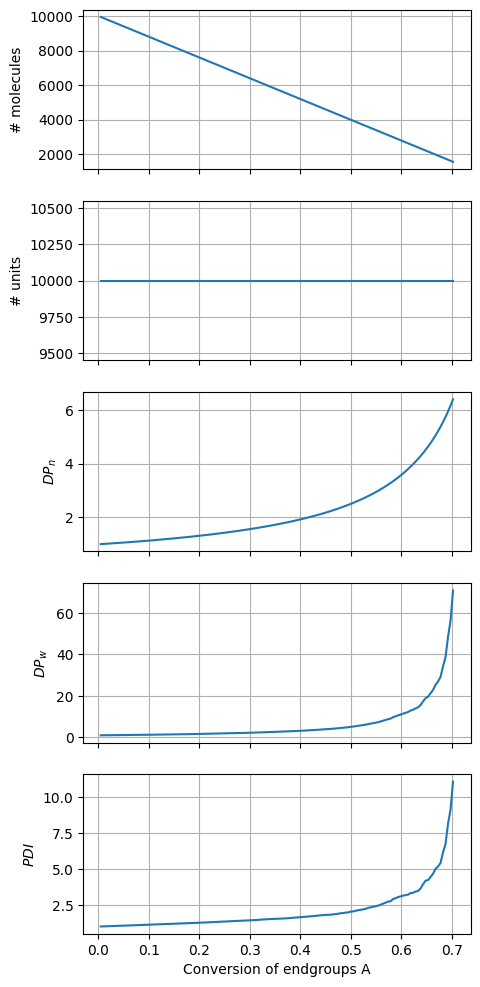

In [7]:
# Compute quantities of interest
stored_states = np.asarray(stored_states)
number_molecules = get_number_molecules(stored_states)
conversion_A = get_conversion_A(stored_states, fA)
moment_1 = get_moment(stored_states, 1)
moment_2 = get_moment(stored_states, 2)
DPn = moment_1/number_molecules
DPw = moment_2/moment_1
PDI = DPw/DPn

# Plots
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(5, 12))

ax[0].set_ylabel("# molecules")
ax[0].plot(conversion_A, number_molecules)
ax[0].grid(True)

ax[1].set_ylabel("# units")
ax[1].plot(conversion_A, moment_1)
ax[1].grid(True)

ax[2].set_ylabel(r"$DP_n$")
ax[2].plot(conversion_A, DPn)
ax[2].grid(True)

ax[3].set_ylabel(r"$DP_w$")
ax[3].plot(conversion_A, DPw)
ax[3].grid(True)

ax[4].set_ylabel(r"$PDI$")
ax[4].plot(conversion_A, PDI)
ax[4].grid(True)

ax[-1].set_xlabel("Conversion of endgroups A")

#### Chain Length Distribution

In [8]:
chain_lengths = get_chain_lengths(stored_states)

CLD = []
for i in range(chain_lengths.shape[0]):
    bins = np.arange(0.5, np.max(chain_lengths[i, :]) + 0.5)
    cld = np.histogram(chain_lengths[i, :], bins=bins, density=True)
    CLD.append(cld)

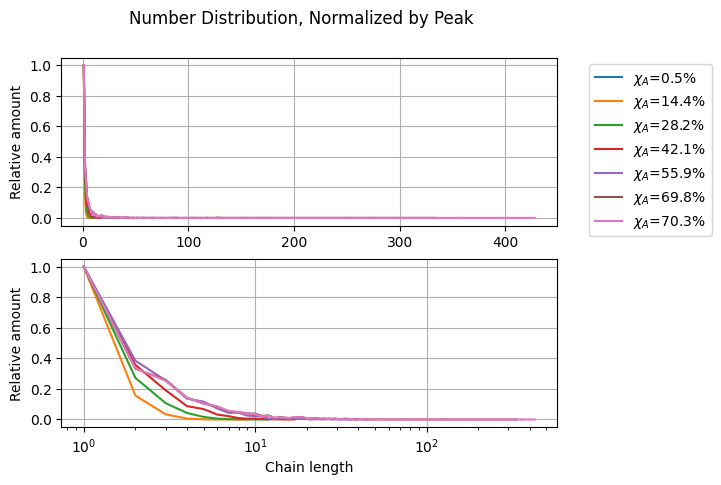

In [9]:
fig2, ax = plt.subplots(2, 1)

fig2.suptitle("Number Distribution, Normalized by Peak")

selected_indexes = [i for i in range(0, len(CLD), round(len(CLD)/5))]
selected_indexes.append(len(CLD)-1)

for i in selected_indexes:
    y, x = CLD[i]
    x = (x[:-1] + x[1:])/2
    y = y/y.max()
    label = r"$\chi_A$=" + f"{100*conversion_A[i]:.1f}%"
    ax[0].plot(x, y, label=label)
    ax[1].semilogx(x, y, label=label)

ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax[-1].set_xlabel("Chain length")
ax[0].set_ylabel("Relative amount")
ax[1].set_ylabel("Relative amount")
ax[0].grid(True)
ax[1].grid(True)

## Questions/Extras

1. Why is the $DP_n$ curve free of stochastic noise (even with low initial number of molecules)?
1. Why is the $DP_w$ curve not smooth (unlike the $DP_n$ curve)?
1. What happens to the distribution when `ratio_endgroups_A_B < 1`? Why?
1. Under which conditions does the algorithm break? Can you fix it?